# Projeto Semantix

Projeto de parceria realizado no curso _Profissão: Cientista de Dados_ da EBAC. 

Seguiremos as etapas da metodologia CRISP-DM com:

* Entendimento do negócio
* Entendimento dos dados
* Preparação dos dados
* Modelagem
* Avaliação do modelo
* Implantação

## Classificação Multiclasse de Categoria de Motocicletas

* Bibliotecas:

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import warnings

warnings.filterwarnings('ignore')

### 1) Entendimento do negócio

* Contexto:

Suponha que uma empresa multinacional na área de motocicletas tenha interesse no mercado de um determinado país. Uma das analises será entender (e prever) as categorias das motocicletas com base na produção (ou importação) de peças deste país para criar uma estratégia de quais modelos
da marca são mais adequados para o perfil dos motociclistas deste país.

* Objetivo:

Contruír um modelo de classificação multiclasse que classifique categorias de motocicletas a partir de dados relacionados a peças e especificações técnicas.

### 2) Levantamento dos Dados

Os [dados](https://www.kaggle.com/datasets/emmanuelfwerr/motorcycle-technical-specifications-19702022?select=all_bikez_curated.csv) foram coletados do site [Kaggle](https://www.kaggle.com/).

* Importação dos dados:

In [298]:
# Importação utilizando a biblioteca Pandas:

dados = pd.read_csv('all_bikez_curated.csv', low_memory=False)

# Visualização de uma amostra do dataset:

dados.sample(n=5)

,Brand,Model,Year,Category,Rating,Displacement (ccm),Power (hp),Torque (Nm),Engine cylinder,Engine stroke,...,Dry weight (kg),Wheelbase (mm),Seat height (mm),Front brakes,Rear brakes,Front tire,Rear tire,Front suspension,Rear suspension,Color options
29968,suzuki,inazuma 400,2002,Naked bike,3.3,399.0,52.0,36.0,In-line four,four-stroke,...,187.0,1460.0,760.0,Dual disc,Single disc,120/70-ZR17 58W,170/60-ZR17 72W,NaN,NaN,NaN
11266,harley-davidson,xlh 1000 sportster,1979,Sport,3.2,997.0,57.0,NaN,V2,four-stroke,...,231.0,NaN,NaN,Single disc,Single disc,100/90-H19,130/90-16,Telehydraulic forks,Dual shocks swinging arm,NaN
2022,bajaj,ct 110x,2022,Allround,NaN,115.5,8.6,9.8,Single cylinder,four-stroke,...,NaN,1285.0,NaN,Expanding brake (drum brake). Combined braking...,Expanding brake (drum brake),2.75-17,3.00-17,"Hydraulic, Telescopic Type",Spring-in-Spring (SNS),"Black/blue, black/red, green, red"
31335,tauris,fiera 125 4t,2011,Scooter,NaN,124.6,NaN,NaN,Single cylinder,four-stroke,...,107.0,NaN,800.0,Single disc,Single disc,130/60-13,130/60-13,Conventional fork,Twin shocks,"Red/white, black/white"
27928,sherco,50cc sm black panther,2008,Super motard,3.3,49.7,NaN,NaN,Single cylinder,two-stroke,...,83.0,1360.0,850.0,Single disc,Single disc,NaN,NaN,Paioli 41mm dia hydraulic telescopic fork Â,"Olle single shock absorber, adjustable spring...",Black


* Exploração e informação básica do dataset:

In [299]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38472 entries, 0 to 38471
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                38472 non-null  object 
 1   Model                38444 non-null  object 
 2   Year                 38472 non-null  int64  
 3   Category             38472 non-null  object 
 4   Rating               21788 non-null  float64
 5   Displacement (ccm)   37461 non-null  float64
 6   Power (hp)           26110 non-null  float64
 7   Torque (Nm)          16634 non-null  float64
 8   Engine cylinder      38461 non-null  object 
 9   Engine stroke        38461 non-null  object 
 10  Gearbox              32675 non-null  object 
 11  Bore (mm)            28689 non-null  float64
 12  Stroke (mm)          28689 non-null  object 
 13  Fuel capacity (lts)  31704 non-null  float64
 14  Fuel system          27844 non-null  object 
 15  Fuel control         22008 non-null 

In [300]:
print(f'Número de linhas: {dados.shape[0]}\nNúmero de colunas: {dados.shape[1]}')

Número de linhas: 38472
Número de colunas: 28


In [301]:
# Visualizando a separação de dados em categóricos e numéricos:

dados_categorica = dados.select_dtypes('object')
dados_numerica = dados.select_dtypes(exclude='object')

list_cat = list(dados_categorica.columns)
list_num = list(dados_numerica.columns)

print(f'Número de colunas com variáveis categóricas: {dados_categorica.shape[1]}.\n  Lista:\n {list_cat}')
print('\n\n')
print(f'Número de colunas com variáveis numericas: {dados_numerica.shape[1]}.\n  Lista:\n {list_num}')

Número de colunas com variáveis categóricas: 18.
  Lista:
 ['Brand', 'Model', 'Category', 'Engine cylinder', 'Engine stroke', 'Gearbox', 'Stroke (mm)', 'Fuel system', 'Fuel control', 'Cooling system', 'Transmission type', 'Front brakes', 'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension', 'Rear suspension', 'Color options']



Número de colunas com variáveis numericas: 10.
  Lista:
 ['Year', 'Rating', 'Displacement (ccm)', 'Power (hp)', 'Torque (Nm)', 'Bore (mm)', 'Fuel capacity (lts)', 'Dry weight (kg)', 'Wheelbase (mm)', 'Seat height (mm)']


In [302]:
# Estatísticas das variáveis categóricas:

dados_categorica.describe().transpose()

,count,unique,top,freq
Brand,38472,576,yamaha,3414
Model,38444,17731,servi-car ge,38
Category,38472,18,Scooter,6669
Engine cylinder,38461,21,Single cylinder,20685
Engine stroke,38461,9,four-stroke,30678
Gearbox,32675,16,6-speed,11904
Stroke (mm),28689,398,66.0,763
Fuel system,27844,2910,Carburettor,7560
Fuel control,22008,14,Double Overhead Cams/Twin Cam (DOHC),7923
Cooling system,34258,3,Air,16931


In [303]:
# Estatísticas das variáveis numéricas:

dados_numerica.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,38472.0,2003.195883,20.083372,1894.0,2000.0,2010.0,2016.0,2022.00
Rating,21788.0,3.401574,0.355631,1.4,3.2,3.4,3.7,4.60
Displacement (ccm),37461.0,552.515072,545.394956,25.0,125.0,397.2,805.0,8277.00
Power (hp),26110.0,50.776040,52.082094,0.3,12.0,30.0,77.0,804.00
Torque (Nm),16634.0,64.527173,63.884654,1.5,12.2,57.0,102.0,712.00
Bore (mm),28689.0,72.596713,18.758621,1.0,57.0,73.0,88.0,176.00
Fuel capacity (lts),31704.0,13.286191,6.010670,0.5,8.2,13.5,17.5,64.34
Dry weight (kg),22483.0,164.151532,85.085133,15.1,105.0,145.0,199.6,1000.00
Wheelbase (mm),25493.0,1423.113521,172.645438,725.0,1321.0,1422.0,1500.0,3327.00
Seat height (mm),24182.0,789.253246,105.492167,39.0,743.0,790.0,830.0,7501.00


* Metadados da base de dados:

In [304]:
# Definindo uma função para criar os metadados de um dataframe

def metadados(df):
    ''' Cria uma tabela com informações do dataframe'''

    meta = pd.DataFrame({'dtypes': df.dtypes})
    meta['nunique'] = df.nunique()
    meta['missing'] = df.isnull().sum()
    meta['missing_pct'] = round(df.isnull().sum()/df.shape[0], 2)
    
    return meta

metadados(dados)

,dtypes,nunique,missing,missing_pct
Brand,object,576,0,0.00
Model,object,17731,28,0.00
Year,int64,129,0,0.00
Category,object,18,0,0.00
Rating,float64,33,16684,0.43
Displacement (ccm),float64,1320,1011,0.03
Power (hp),float64,716,12362,0.32
Torque (Nm),float64,723,21838,0.57
Engine cylinder,object,21,11,0.00
Engine stroke,object,9,11,0.00


* Análise Univariada:

Nesta sessão podemos nos aprofundar no entendimento de cada variável como sua distribuição, estabilidade no tempo e assim por diante.

In [305]:
# Abandonando algumas variáveis não relacionadas com a análise:

dados_numerica.drop(['Rating', 'Year'], axis=1, inplace=True)
dados_categorica.drop(['Brand', 'Model'], axis=1, inplace=True)
dados.drop(['Rating', 'Brand', 'Year', 'Model'], axis=1, inplace=True)

In [306]:
# Definindo uma função para gerar um gráfico de barras de uma variável categórica:

def graf_bar(df, var):
    """ Recebe um dataframe e uma string de variável categórica e retorna
    um barplot
    """
    g = df[var].value_counts().sort_values()

    plt.figure(figsize=(12,8))
    sns.barplot(x=g.index, y=g)
    plt.title(f'Distribuição de {var}')
    plt.ylabel('Contagem')
    plt.xticks(rotation=60)


Distribuição da variável alvo:

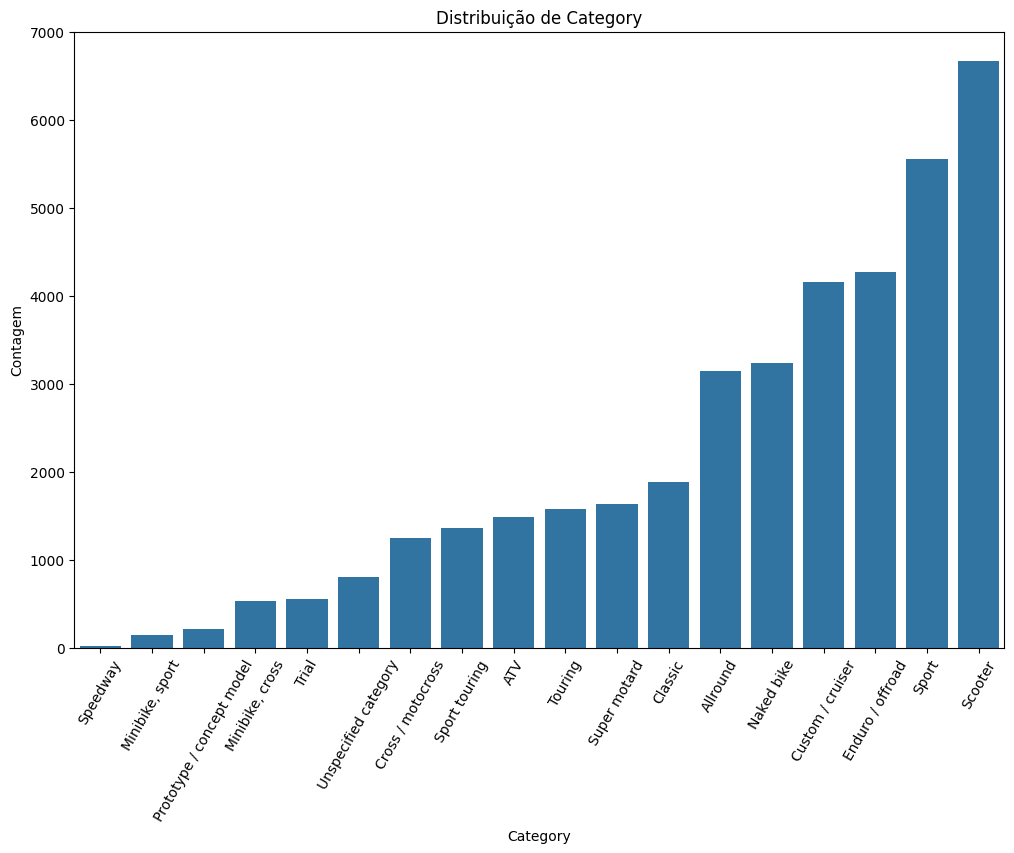

In [307]:
graf_bar(dados, 'Category')


Existem algumas classes pouco presentes, indicando que possívelmente um agrupamento das classes e/ou remoção de classes pode ser viável para a construção do modelo.

Distribuição de variáveis alvo:

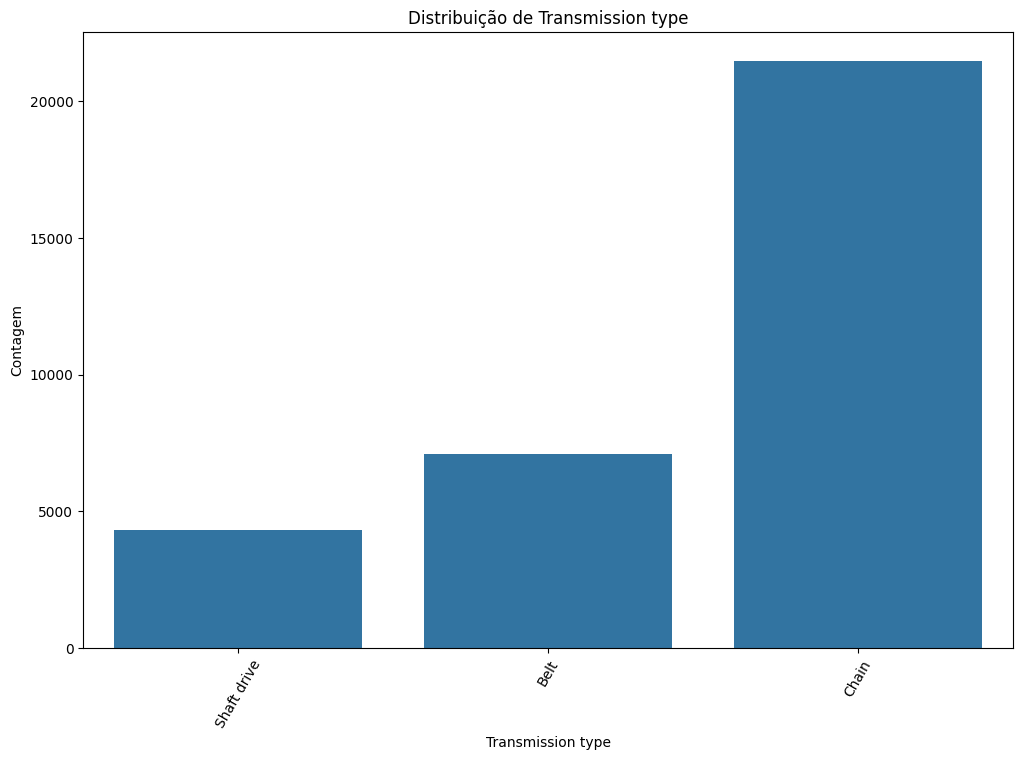

In [308]:
graf_bar(dados, 'Transmission type')

Distribuição de variáveis numéricas:

In [309]:
# Definindo uma função para gerrar um histograma de uma variável continua

def graf_hist(df, var, bins, hue=None):
    """ Recebe um dataframe, uma string de variável numérica e o número de bins e retorna
    um histograma
    """
    plt.figure(figsize=(15,8))
    sns.histplot(data=df, x=var, bins=bins, hue=hue)
    plt.title(f'Boxplot: {var}')
    plt.ylabel('Contagem')

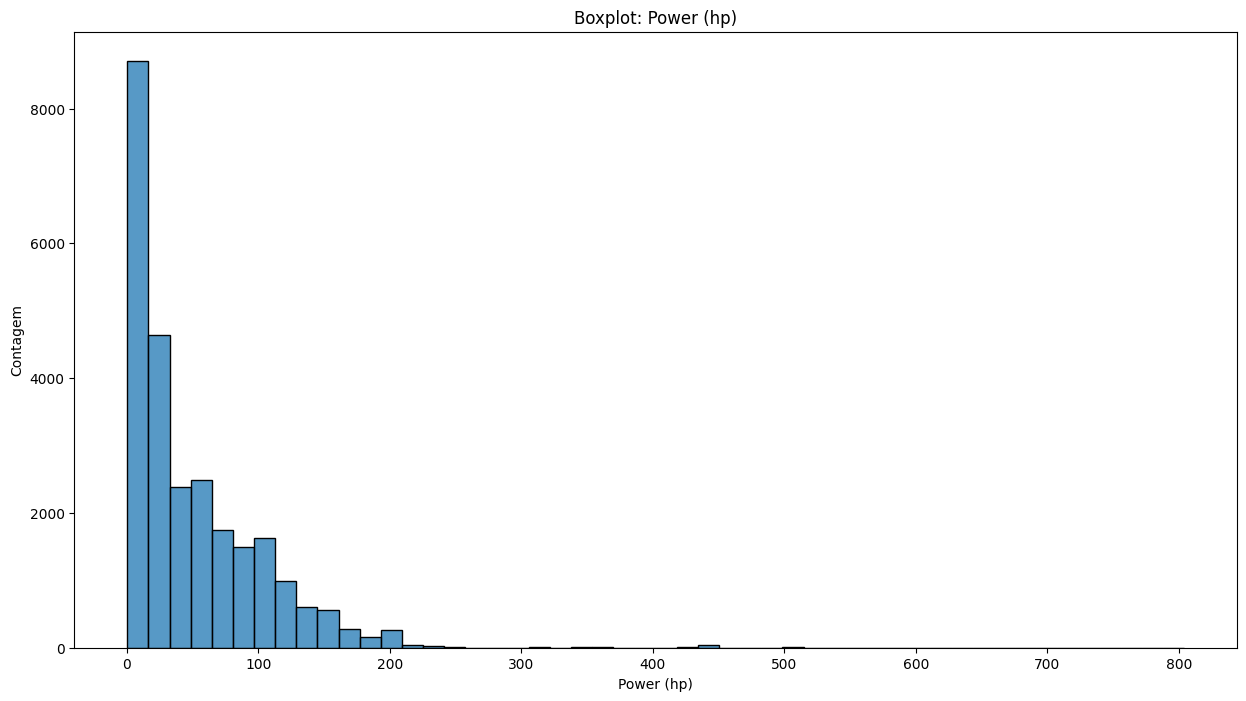

In [310]:
graf_hist(dados, 'Power (hp)', 50)

A Potência é fortemente concentrada em valores abaixo de 50hp. Para comparação, uma moto usual de transporte urbano tem cerca de 15hp.

Para explorar a existência de outliers nos dados mais distântes da média, podemos utilizar boxplots, que nos dão informação gráfica relacionada aos quartis da variável:

In [311]:
# Definindo uma função para gerar boxplot de uma variável

def graf_box(df, var):
    """ Recebe um dataframe e uma string de variável categórica e retorna
    um boxplot
    """
    plt.figure(figsize=(15,8))
    sns.boxplot(y=df[var])
    plt.title(f'Boxplot: {var}')
    plt.ylabel('Renda média')

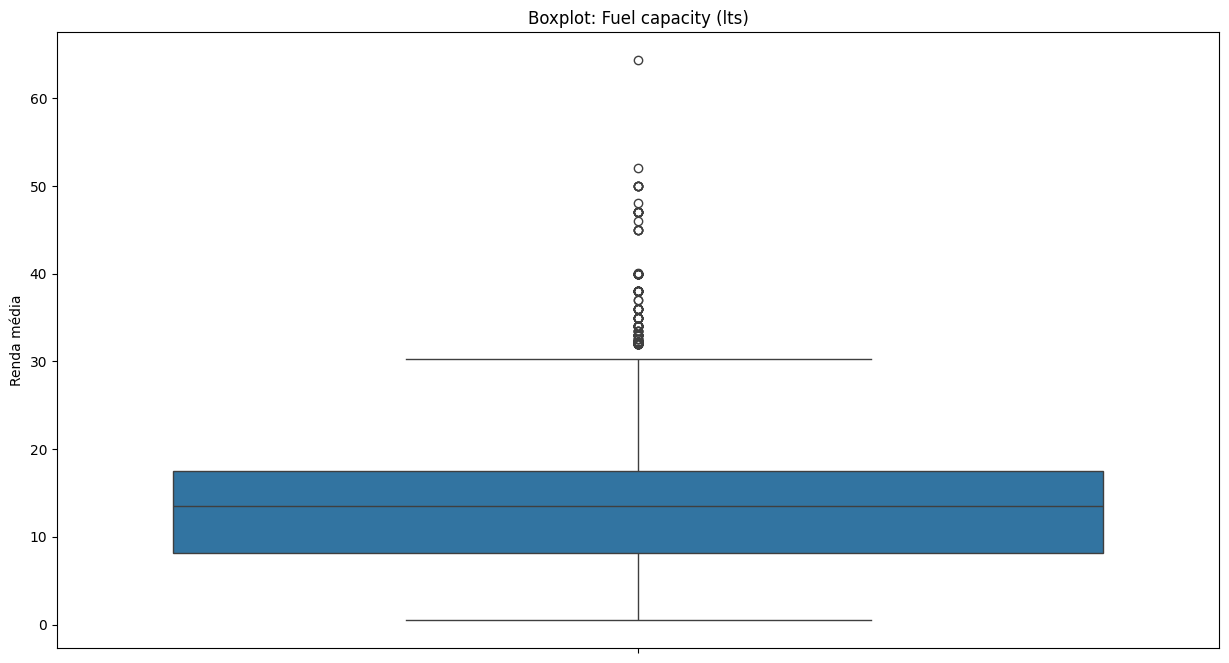

In [312]:
graf_box(dados, 'Fuel capacity (lts)')

Diversos pontos acima do limite superior, indicando a presença de outliers.

Antes de iniciar a análise bivariada, daremos atenção as classes da variável alvo. Algumas classes são muito semelhantes e pertencem a categorias muito próximas. Outras classes tem baixíssima ocorrência, afetando a qualidade final do modelo.

In [313]:
pct_classes = dados['Category'].value_counts()/dados.shape[0]
pct_classes

Category
Scooter                      0.173347
Sport                        0.144313
Enduro / offroad             0.110912
Custom / cruiser             0.108131
Naked bike                   0.084269
Allround                     0.081644
Classic                      0.048945
Super motard                 0.042472
Touring                      0.040887
ATV                          0.038496
Sport touring                0.035454
Cross / motocross            0.032309
Unspecified category         0.020924
Trial                        0.014504
Minibike, cross              0.013750
Prototype / concept model    0.005433
Minibike, sport              0.003665
Speedway                     0.000546
Name: count, dtype: float64

In [314]:
lista = [classe for classe, valor in pct_classes.items() if valor < 0.01]

print(f'Lista de baixa occorência:\n {lista}')

Lista de baixa occorência:
 ['Prototype / concept model', 'Minibike, sport', 'Speedway']


In [315]:
# removendo classes com menos de 1% de ocorrência no dataset e a categoria sem especificação e ATVs:

lista.append('Unspecified category')
lista.append('ATV')

dados = dados.loc[~dados['Category'].isin(lista)]

In [316]:

dados['Category'].value_counts()

Category
Scooter              6669
Sport                5552
Enduro / offroad     4267
Custom / cruiser     4160
Naked bike           3242
Allround             3141
Classic              1883
Super motard         1634
Touring              1573
Sport touring        1364
Cross / motocross    1243
Trial                 558
Minibike, cross       529
Name: count, dtype: int64

As classes 'Enduro / offroad', 'Super motard' e 'Cross / motocross' são categorias de motocicletas muito semelhantes, vamos visualizar isto:

In [317]:
cross = ['Enduro / offroad', 'Super motard' , 'Cross / motocross', 'Trial', 'Minibike, cross']

df_cross = dados.loc[dados['Category'].isin(cross)]

In [318]:
df_cross.Category.value_counts()

Category
Enduro / offroad     4267
Super motard         1634
Cross / motocross    1243
Trial                 558
Minibike, cross       529
Name: count, dtype: int64

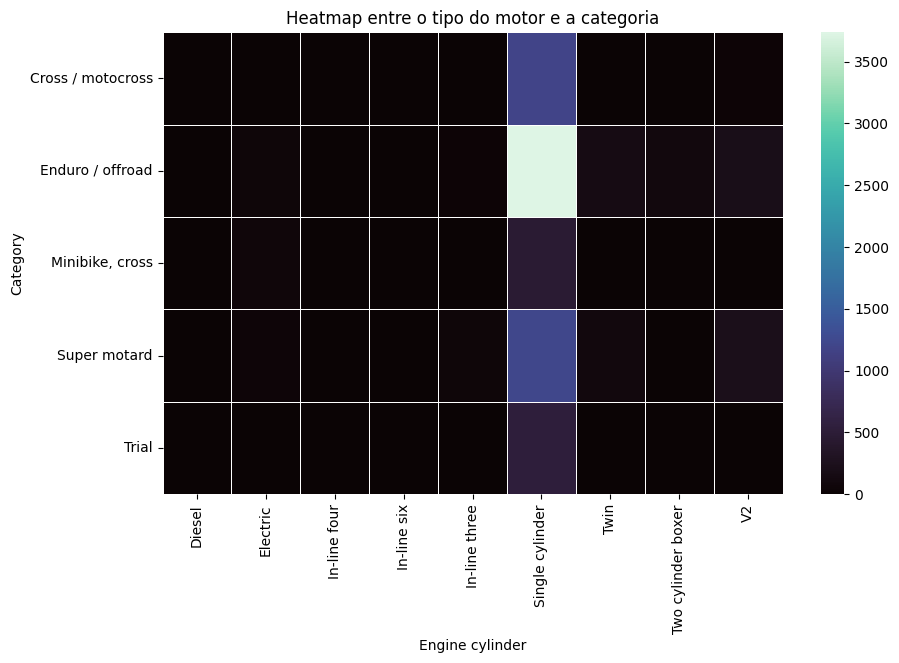

In [319]:
plt.figure(figsize=(10, 6))

heatmap_data = df_cross.groupby(['Category', 'Engine cylinder']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='mako', fmt='d', linewidths=.5)

plt.title('Heatmap entre o tipo do motor e a categoria')

plt.show()

Estas classes são majoritariamentes monocilindricas.

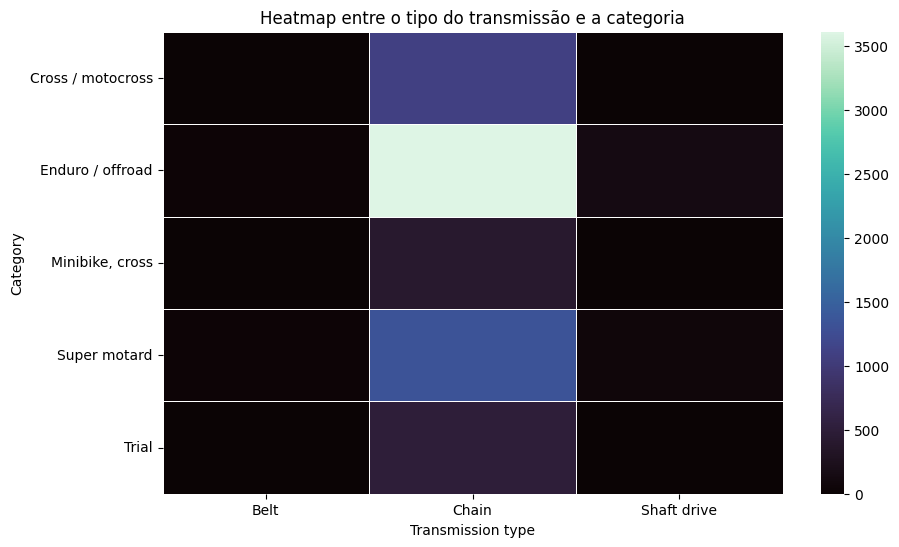

In [320]:
plt.figure(figsize=(10, 6))

heatmap_data = df_cross.groupby(['Category', 'Transmission type']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='mako', fmt='d', linewidths=.5)

plt.title('Heatmap entre o tipo do transmissão e a categoria')

plt.show()

A transmissão é em maioria por corrente.

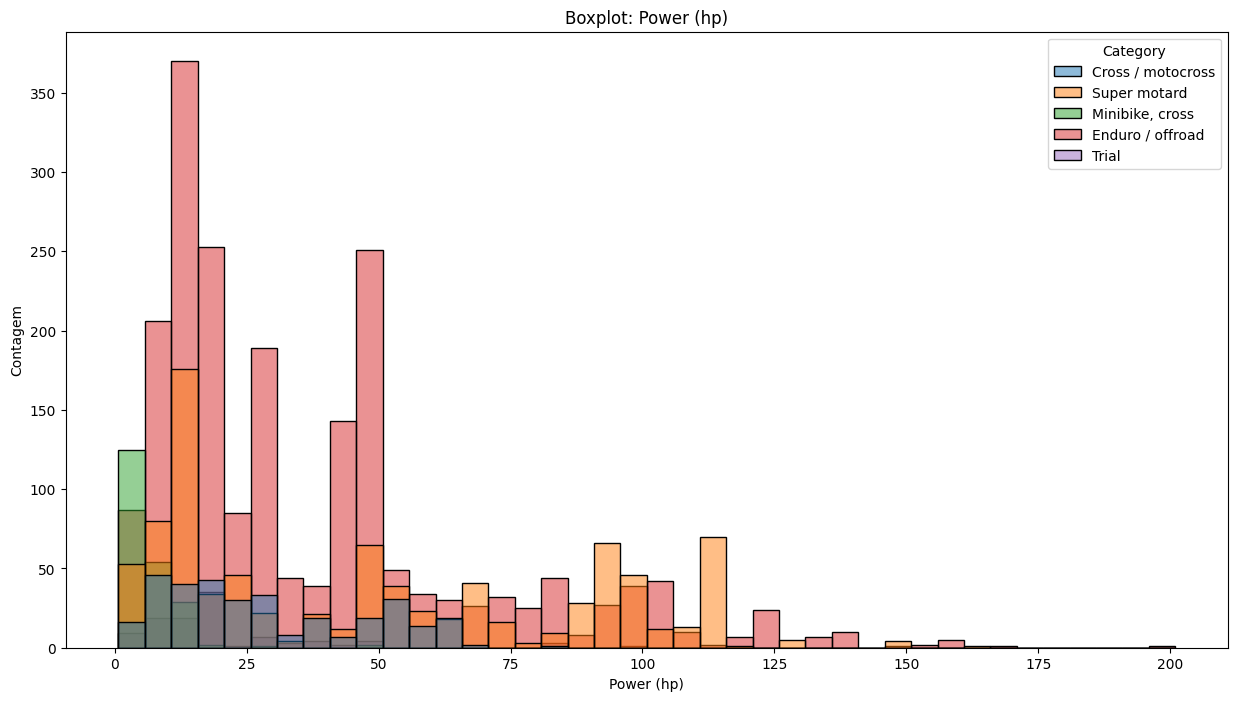

In [321]:
graf_hist(df_cross, 'Power (hp)', 40, hue='Category')

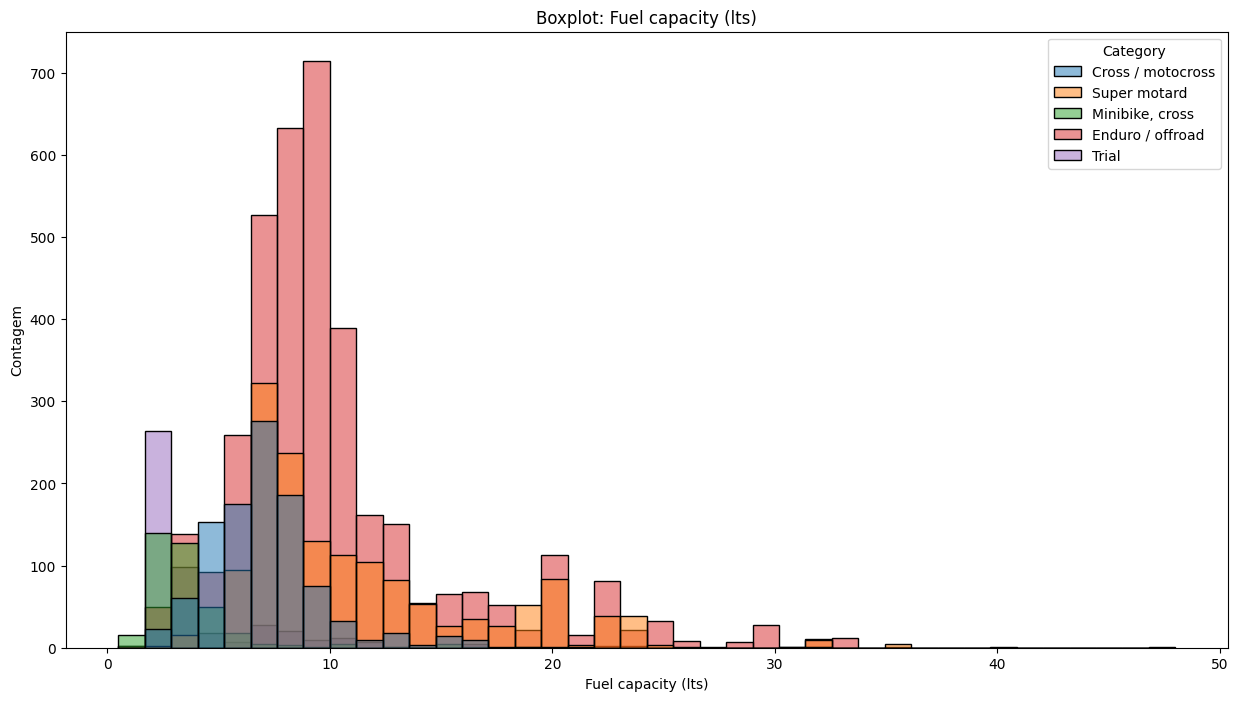

In [322]:
graf_hist(df_cross, 'Fuel capacity (lts)', 40, hue='Category')

Ao analisar mais variáveis podemos concluir que estas 4 classes são muito semelhantes, tanto em "estilo" quanto em especificações. Com isso podemos agrupar estas classes no classe 'Cross / enduro':

In [323]:
dados['Category'].replace({
    'Cross / motocross': 'Cross / enduro',
    'Super motard': 'Cross / enduro',
    'Enduro / offroad': 'Cross / enduro',
    'Trial': 'Cross / enduro',
    'Minibike, cross': 'Cross / enduro'
}, inplace=True)

print(f'Categorias: \n {dados['Category'].unique()}')

Categorias: 
 ['Sport' 'Scooter' 'Allround' 'Naked bike' 'Custom / cruiser'
 'Cross / enduro' 'Classic' 'Touring' 'Sport touring']


* Análise bivariada:

Nesta sessão exploramos a relação entre os dados, colinearidade e mais.

In [324]:
# Explorando a correlação entre as variáveis numéricas:

df_corr = dados_numerica.corr(method='spearman')
df_corr

,Displacement (ccm),Power (hp),Torque (Nm),Bore (mm),Fuel capacity (lts),Dry weight (kg),Wheelbase (mm),Seat height (mm)
Displacement (ccm),1.000000,0.919568,0.977892,0.840754,0.764843,0.845247,0.733725,-0.101051
Power (hp),0.919568,1.000000,0.920155,0.734959,0.753964,0.794380,0.664486,0.226205
Torque (Nm),0.977892,0.920155,1.000000,0.828162,0.771999,0.800798,0.708385,-0.011513
Bore (mm),0.840754,0.734959,0.828162,1.000000,0.546628,0.704763,0.645858,0.048487
Fuel capacity (lts),0.764843,0.753964,0.771999,0.546628,1.000000,0.832431,0.568893,-0.037337
Dry weight (kg),0.845247,0.794380,0.800798,0.704763,0.832431,1.000000,0.678819,-0.216964
Wheelbase (mm),0.733725,0.664486,0.708385,0.645858,0.568893,0.678819,1.000000,-0.111444
Seat height (mm),-0.101051,0.226205,-0.011513,0.048487,-0.037337,-0.216964,-0.111444,1.000000


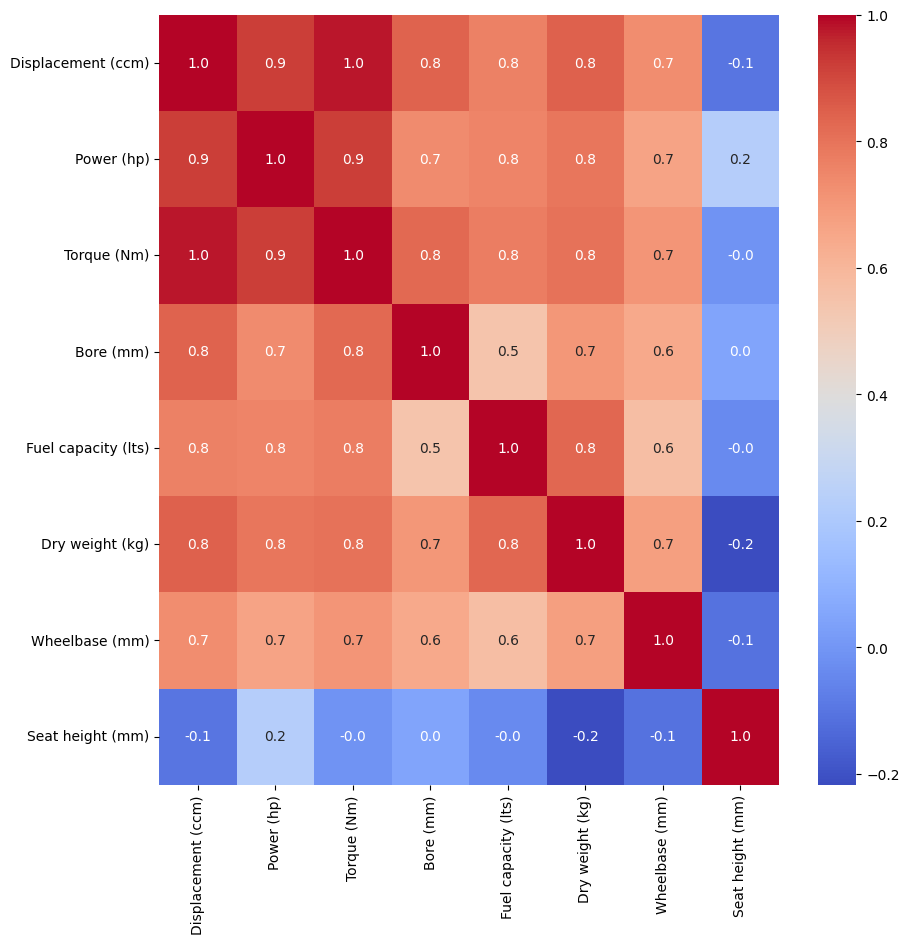

In [325]:
# Criando um heatmap para visualizar melhor a correlação:

plt.figure(figsize=(10,10))
sns.heatmap(df_corr, annot=True, fmt='.1f', cmap='coolwarm')
plt.show()

Podemos notar que existem diversas variáveis com alta correlação (acima de 0.7) indicando um problema de multicolinearidade. Para contornarmos o problema podemos utilizar uma análise de componentes principais durante a criação da pipeline do modelo.

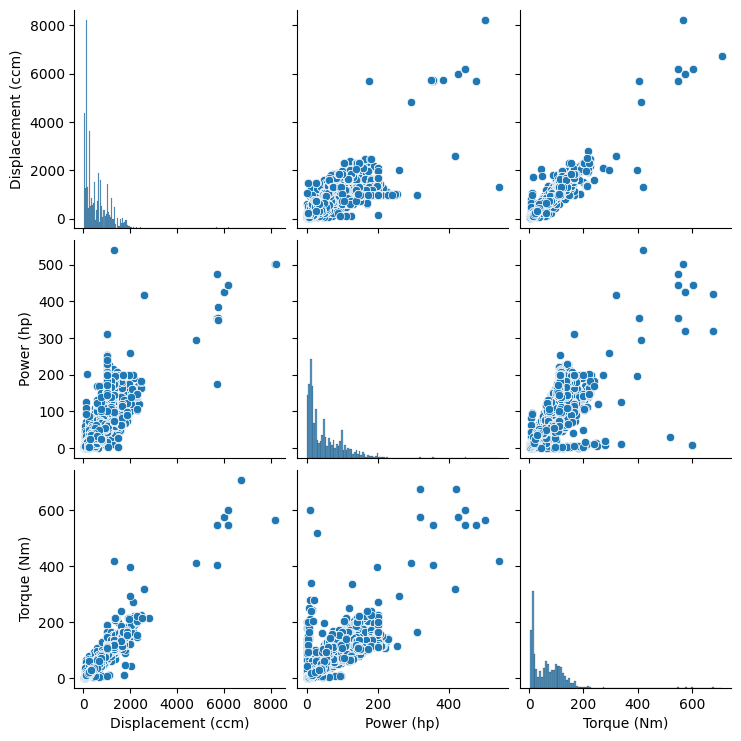

In [326]:
# Explorando a relação entre algumas variáveis numéricas fortemente correlacionadas:

sns.pairplot(data=dados[[
    'Displacement (ccm)', 
    'Power (hp)', 
    'Torque (Nm)', 
    'Category']])

Podemos notar uma relação fortemente linear entre estas 3 variáveis, ao realizar o PCA poderemos 

Analisar a variável categórica pode nos ajudar a identificar variáveis que mais discriminam as classes e possivelmente indicar novas classes altamente semelhantes.

In [327]:
def graf_point(df, var):
    ''' Gera um poitplot ordenado de uma variável numérica em relação a categoria'''

    order = df.groupby('Category')[var].mean().sort_values().index
    
    sns.pointplot(data=df, x='Category', y=var, order=order)
    plt.title(f'Pointplot da categoria em relação a {var}')
    plt.xticks(rotation=45)

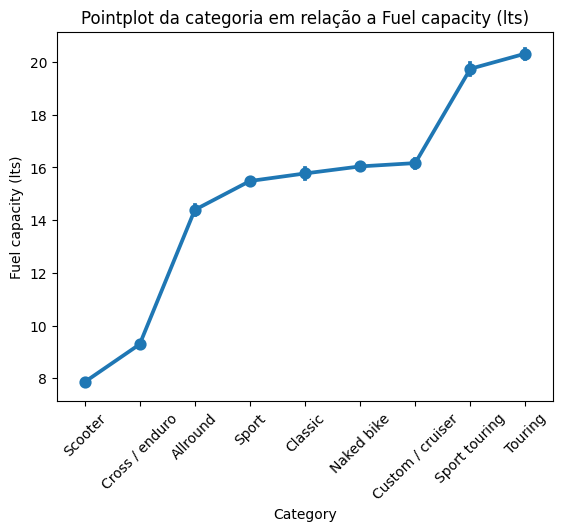

In [328]:
graf_point(dados, 'Fuel capacity (lts)')

In [329]:
dados_numerica.columns

Index(['Displacement (ccm)', 'Power (hp)', 'Torque (Nm)', 'Bore (mm)',
       'Fuel capacity (lts)', 'Dry weight (kg)', 'Wheelbase (mm)',
       'Seat height (mm)'],
      dtype='object')

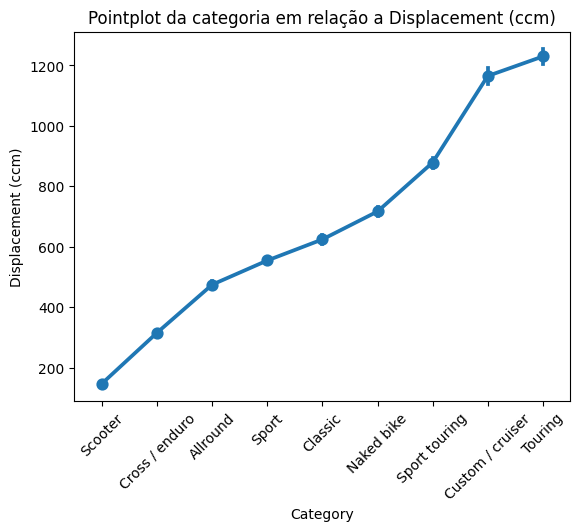

In [330]:
graf_point(dados, 'Displacement (ccm)')

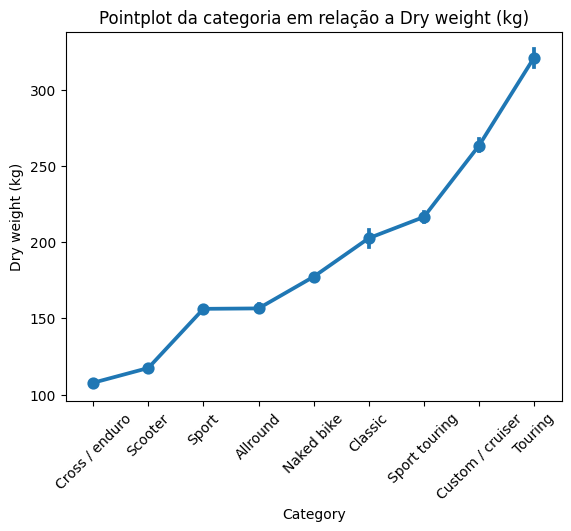

In [331]:
graf_point(dados, 'Dry weight (kg)')

Notamos o padrão de motos voltadas a viagens terem um motor de maior tamanho e pesarem mais, importante notar que o peso da moto e o tamanho do motor são variáveis fortemente correlacionadas.

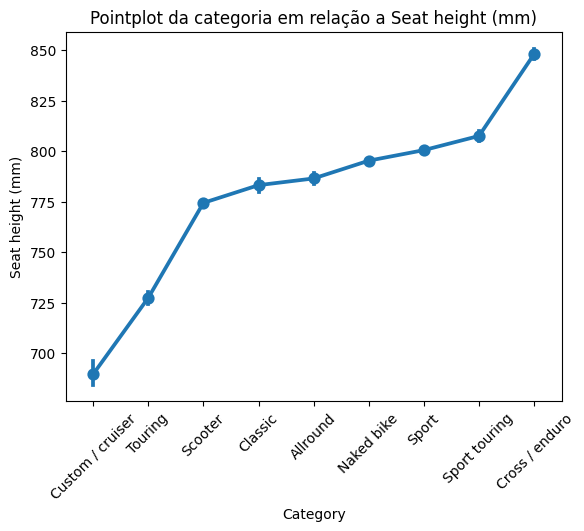

In [332]:
graf_point(dados, 'Seat height (mm)')

Por questões de praticidade do projeto, analisamos alugmas variáveis e suas relações. Porém para tirar o máximo de valor dos dados e gerar novos insights devemos aprofundar esta etapa de entendimento dos dados.

In [333]:
# Com análises feitas, podemos reduzir as classes através de agrupamentos:

dados['Category'].replace({
        'Allround': 'Urban / classic',
        'Classic': 'Urban / classic',
        'Touring' : 'Touring',
        'Sport touring': 'Touring',
        'Naked bike': 'Sport / naked',
        'Sport': 'Sport / naked'
}, inplace=True)

In [334]:
dados['Category'].unique()

array(['Sport / naked', 'Scooter', 'Urban / classic', 'Custom / cruiser',
       'Cross / enduro', 'Touring'], dtype=object)

### 3) Preparação dos Dados

Nesta etapa do projeto, realizaremos algumas operações e transformações para preparar os dados para o modelo.

Já realizamos algumas seleções na variável alvo. Para melhorar nossa análise, iremos fazer uma remoção de outliers baseado na dstância interquartil e criaremos uma pipeline para tratar dados faltantes, realizar encoding, padronização e uma PCA nos dados.

In [335]:
# Relembrando os metadados:

metadados(dados)

,dtypes,nunique,missing,missing_pct
Category,object,6,0,0.00
Displacement (ccm),float64,1240,950,0.03
Power (hp),float64,697,11224,0.31
Torque (Nm),float64,707,19798,0.55
Engine cylinder,object,20,11,0.00
Engine stroke,object,9,11,0.00
Gearbox,object,15,5477,0.15
Bore (mm),float64,280,9053,0.25
Stroke (mm),object,383,9053,0.25
Fuel capacity (lts),float64,432,6500,0.18


Notamos que mais da metade dos dados relacionados ao 'Torque' são faltantes. Como esta variável esta fortemente correlacionada com outras variáveis, podemos excluir esta variável do modelo sem perder muita informação:

In [336]:
dados.drop(columns=['Torque (Nm)'], inplace=True)

In [337]:
# Recarregando as separações feitas nos dados:

dados_categorica = dados.select_dtypes('object').drop(columns=['Category'])
dados_numerica = dados.select_dtypes(exclude='object')

list_cat = dados_categorica.columns
list_num = dados_numerica.columns

print(f'Número de colunas com variáveis categóricas: {dados_categorica.shape[1]}.\n  Lista:\n {list_cat}')
print('\n\n')
print(f'Número de colunas com variáveis numericas: {dados_numerica.shape[1]}.\n  Lista:\n {list_num}')

Número de colunas com variáveis categóricas: 15.
  Lista:
 Index(['Engine cylinder', 'Engine stroke', 'Gearbox', 'Stroke (mm)',
       'Fuel system', 'Fuel control', 'Cooling system', 'Transmission type',
       'Front brakes', 'Rear brakes', 'Front tire', 'Rear tire',
       'Front suspension', 'Rear suspension', 'Color options'],
      dtype='object')



Número de colunas com variáveis numericas: 7.
  Lista:
 Index(['Displacement (ccm)', 'Power (hp)', 'Bore (mm)', 'Fuel capacity (lts)',
       'Dry weight (kg)', 'Wheelbase (mm)', 'Seat height (mm)'],
      dtype='object')


In [338]:
# Separando dados de treino e validação:

X = dados.drop(columns=['Category'])
y = dados['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


* Remoção de outliers nas variáveis numéricas:

In [339]:
# Substituindo outliers pela mediana:

def outliers_sub(df, val):
    ''' Substituí os outliers da variável pela mediana '''
    q1 = df[val].quantile(0.25)
    q3 = df[val].quantile(0.75)
    iqr = q3 - q1

    mediana = df[val].median()

    filtro = (df[val] >= q1 - 1.5*iqr) & (df[val] <= q3 + 1.5*iqr)
    #df.loc[~filtro, val] = mediana
    df[val] = np.where(~filtro, mediana, df[val])

    return df

def substituir_outliers(df):
    ''' Substituí os outliers das variáveis numericas no dataframe pelas medianas'''
    for i in list_num:
        df[i] = outliers_sub(df, i)[i]
    return df

In [340]:
# Substituindo os outliers na base de dados de treino

X_train_sub = substituir_outliers(X_train)

In [341]:
# Etapas da pipeline:

# Imputação de dados faltantes:

impt_num = SimpleImputer(strategy='mean')
impt_cat = SimpleImputer(strategy='most_frequent')

# Criação de dummies:

dummies = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Column transformers:

prep = ColumnTransformer(
    transformers=[
        ('num', impt_num, list_num),
        ('cat', Pipeline(steps=[
            ('imputer', impt_cat),
            ('encoding', dummies)
        ]), list_cat)
])


# Scaler:

scaler = StandardScaler()

# PCA:

pca = PCA(n_components=7)


In [342]:
# Pipeline final:

pipe = Pipeline(steps=[
    ('preprocessor', prep),
    ('scaler', scaler),
    ('pca', pca)
])

# fitando nos dados de treino:

pipe.fit(X_train_sub, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['Displacement (ccm)', 'Power (hp)', 'Bore (mm)', 'Fuel capacity (lts)',
       'Dry weight (kg)', 'Wheelbase (mm)', 'Seat height (mm)'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Engine cylinder', 'Engine stroke', 'Gearbox', 'Stroke (mm)',
       'Fuel system', 'Fuel control', 'Cooling system', 'Transmission type',
       'Front brakes', 'Rear brakes', 'Front tire', 'Rear tire',
       'Front suspension', 'Rear suspension', 'Color options'],
      dtype='object'))])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=7))])

In [343]:
# Features de treino e teste do modelo:

X_train_final = pipe.transform(X_train_sub)
X_test_final = pipe.transform(X_test)

X_train_final

array([[ 1.43940907, -1.31582567, -0.37948165, ...,  0.82604867,
        -0.64875159, -0.34031065],
       [-0.51017249,  0.35602709,  0.34372015, ..., -0.49000538,
         0.36676861,  0.10684519],
       [-4.37220794,  2.08092184, -0.05563011, ..., -0.23861222,
        -0.078857  , -0.09983473],
       ...,
       [-3.20356954,  3.01690245,  0.4152113 , ..., -1.14862361,
         1.61729428, -0.02533292],
       [-2.95290349,  0.93325156, -0.07590682, ...,  0.17755527,
        -0.01356593, -0.25801405],
       [ 3.27519362, -4.45995349, -0.11282916, ...,  0.79172984,
        -1.17060758,  0.5377125 ]])

### 4) Modelagem

Aqui iremos construir e comparar alguns modelos de classificação, após escolher o melhor modelo, vamos tunar os hiperparâmetros e fazer a validação do modelo:

In [344]:
KNC = cross_validate(KNeighborsClassifier(), X_train_final, y_train, scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'])

OvsR = cross_validate(OneVsRestClassifier(estimator=LogisticRegression()), X_train_final, y_train, scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'])

RFC = cross_validate(RandomForestClassifier(n_jobs=-1), X_train_final, y_train, scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'])

In [345]:
resultados = pd.DataFrame({
    'label': ['accuracy', 'f1_macro', 'roc_auc_ovr'],
    'KNeighborsClassifier': [KNC['test_accuracy'].mean(), KNC['test_f1_macro'].mean(), KNC['test_roc_auc_ovr'].mean()],
    'OneVsRestClassifier': [OvsR['test_accuracy'].mean(), OvsR['test_f1_macro'].mean(), OvsR['test_roc_auc_ovr'].mean()],
    'RandomForestClassifier': [RFC['test_accuracy'].mean(), RFC['test_f1_macro'].mean(), RFC['test_roc_auc_ovr'].mean()]
}).set_index('label')

resultados.index.name=None
resultados = resultados.transpose()

resultados

,accuracy,f1_macro,roc_auc_ovr
KNeighborsClassifier,0.738373,0.714077,0.912305
OneVsRestClassifier,0.572397,0.501935,0.848311
RandomForestClassifier,0.785361,0.763270,0.949027


- Acurácia - mede a proporção de predições corretas em relação ao total de predições.

- f1 Score - média harmônica entre a precisão e o recall.

- ROC AUC - mede a capacidade do modelo de distinguir classes diferentes.

O modelo de RandomForestClassifier apresenta as melhores métricas para os dados de treino. Vamos seguir com este modelo.

In [346]:
kfold = StratifiedKFold(n_splits=4, shuffle=True)

RF = RandomForestClassifier(n_jobs=-1)

parametros = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(50,500,50),
    'max_depth': range(1,12),
    'min_samples_split': range(2,10,2),
    'min_samples_leaf': range(2,10,2)
}

search = RandomizedSearchCV(RF, parametros, scoring='accuracy', cv=kfold)
resultado = search.fit(X_test_final, y_test)

print("Melhores parâmetros encontrados:", resultado.best_params_)

Melhores parâmetros encontrados: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 11, 'criterion': 'gini'}


In [351]:
# Modelo final com os parâmetros optimizados:

RF_final = RandomForestClassifier(
    n_jobs=-1,
    criterion = 'gini',
    n_estimators = 250,
    max_depth= 11,
    min_samples_split= 2,
    min_samples_leaf= 4
)

RF_final.fit(X_train_final,y_train)

RandomForestClassifier(max_depth=11, min_samples_leaf=4, n_estimators=250,
                       n_jobs=-1)

### 5) Avaliação dos resultados

In [352]:
# Calculando as métricas para previsões feitas com os dados de treino
# e teste

acc_treino = accuracy_score(y_train, RF_final.predict(X_train_final))
roc_treino = roc_auc_score(y_train, RF_final.predict_proba(X_train_final), multi_class='ovr')

X_test_final = pipe.transform(X_test)


acc_teste = accuracy_score(y_test, RF_final.predict(X_test_final))
roc_teste = roc_auc_score(y_test, RF_final.predict_proba(X_test_final), multi_class='ovr')


resultados = pd.DataFrame({
    'label': ['accuracy', 'ROC AUC'],
    'Treino': [round(acc_treino,4), round(roc_treino,4)],
    'Teste:': [round(acc_teste,4), round(roc_teste,4)]
}).set_index('label')

resultados.index.name=None
resultados = resultados.transpose()

resultados

,accuracy,ROC AUC
Treino,0.8035,0.9702
Teste:,0.7286,0.9394


Obtemos boas métricas para o conjunto de teste, demonstrando que o modelo consegue prever novos dados.

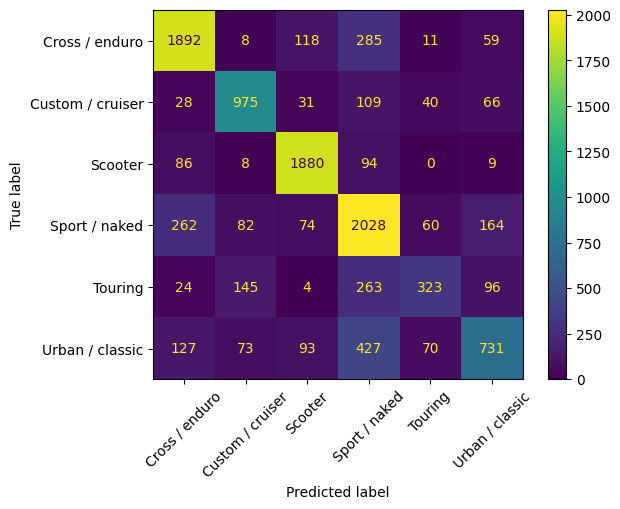

In [354]:
# Matriz de confusão da base de teste:

y_pred = RF_final.predict(X_test_final)
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=list(RF_final.classes_))
matrix.plot()

plt.xticks(rotation=45)
plt.show()

Com a matriz de confusão construímos uma tabela cruzada entre os valores reais e preditos das classes. A diagonal principal representa as predições corretas do modelo.

No geral o modelo consegue classificar bem os dados da base de teste.

In [356]:
# Métricas finais na base de teste:

report = classification_report(y_test, y_pred)

print(report)

                  precision    recall  f1-score   support

  Cross / enduro       0.78      0.80      0.79      2373
Custom / cruiser       0.76      0.78      0.77      1249
         Scooter       0.85      0.91      0.88      2077
   Sport / naked       0.63      0.76      0.69      2670
         Touring       0.64      0.38      0.48       855
 Urban / classic       0.65      0.48      0.55      1521

        accuracy                           0.73     10745
       macro avg       0.72      0.68      0.69     10745
    weighted avg       0.73      0.73      0.72     10745



## Conclusão:

O modelo apresenta bons resultados para a classificação de diferentes categorias utilizando os dados disponíveis, concluíndo o objetivo inicial do projeto.